# Homework 3
DASC 522  
Richy Peterson

## Preamble

In [1]:
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm

# for regression
import statsmodels.formula.api as smf
from sklearn import datasets
from statistics import mean

## Import Database

In [2]:
# Read database
my_connection=sqlite3.connect("weather_data-1.db")
my_cursor=my_connection.cursor()

## Section 1: Data Loading & Preparation


Get Table Names

In [3]:
query_result = my_cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(query_result.fetchall())

[('X_table',), ('y_table',)]


X_table

In [4]:
data_X = my_cursor.execute("SELECT * FROM X_table").fetchall()
X_column_names = []
for column in query_result.description:
    X_column_names.append(column[0])
df_X = pd.DataFrame(data_X, columns=X_column_names).drop(columns=['MONTH','DAY','IF4PMTO7AM'],axis=1)
df_X.head()

MONTHDAY  HOUR  DEWPOINTTEMPERATURE  SEALEVELPRESSURE  TEMP1  TEMP2  TEMP3  TEMP4  TEMP5  TEMP6  Record_ID
0       1.0     1                    3            1021.5      8      9     12     13     13     13          1
1       1.0     2                    3            1021.7      8      8      9     12     13     13          2
2       1.0     3                    3            1021.7      7      8      8      9     12     13          3
3       1.0     4                    3            1021.3      7      7      8      8      9     12          4
4       1.0     5                    3            1021.0      7      7      7      8      8      9          5

y_table

In [5]:
data_y = my_cursor.execute("SELECT * FROM Y_table").fetchall()
y_column_names = []
for column in query_result.description:
    y_column_names.append(column[0])
df_y = pd.DataFrame(data_y,columns=y_column_names)
df_y.head()

Record_ID  AIRTEMPERATURE
0      17163             -14
1      17162             -14
2      17043             -13
3      17040             -13
4       8705             -13

A. Use the df.merge() class method to merge the two dataframes on the "Record_ID" column, into a dataframe called df_new. Then, drop the "Record_ID" column

In [19]:
df_new = df_X.merge(df_y,on='Record_ID').drop('Record_ID',axis=1)
df_new.head()

MONTHDAY  HOUR  DEWPOINTTEMPERATURE  SEALEVELPRESSURE  TEMP1  TEMP2  TEMP3  TEMP4  TEMP5  TEMP6  AIRTEMPERATURE
0       1.0     1                    3            1021.5      8      9     12     13     13     13               8
1       1.0     2                    3            1021.7      8      8      9     12     13     13               7
2       1.0     3                    3            1021.7      7      8      8      9     12     13               7
3       1.0     4                    3            1021.3      7      7      8      8      9     12               7
4       1.0     5                    3            1021.0      7      7      7      8      8      9               6

B. Split df_new into X & y dataframes, where y only contains the AIRTEMPERATURE feature

In [20]:
X = df_new.loc[:,df_new.columns != 'AIRTEMPERATURE']
X = sm.add_constant(X)
y = df_new.loc[:,df_new.columns == 'AIRTEMPERATURE']

## Section 2: Data Understanding / Modeling

A. Create a Data Understanding table & two python Data Understanding visualizations such as a scatterplot, histogram, pairplot, or correlation matrix.

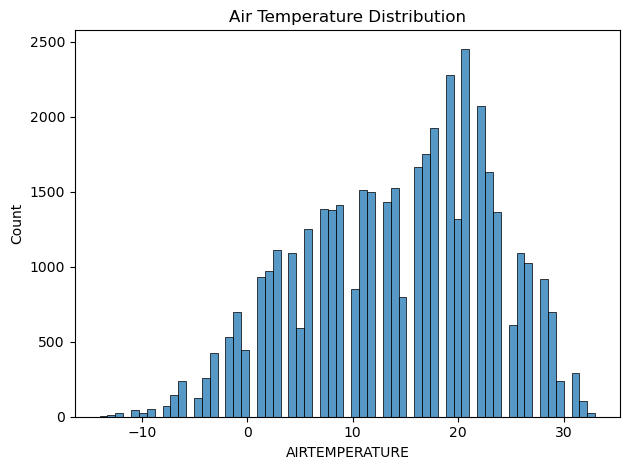

In [21]:
fig,ax = plt.subplots()
sns.histplot(y['AIRTEMPERATURE'],ax=ax)
ax.set_title('Air Temperature Distribution')
fig.tight_layout()

    Airtemperature distribution is not quite normal, but resembles normal with a spike at 20 deg.

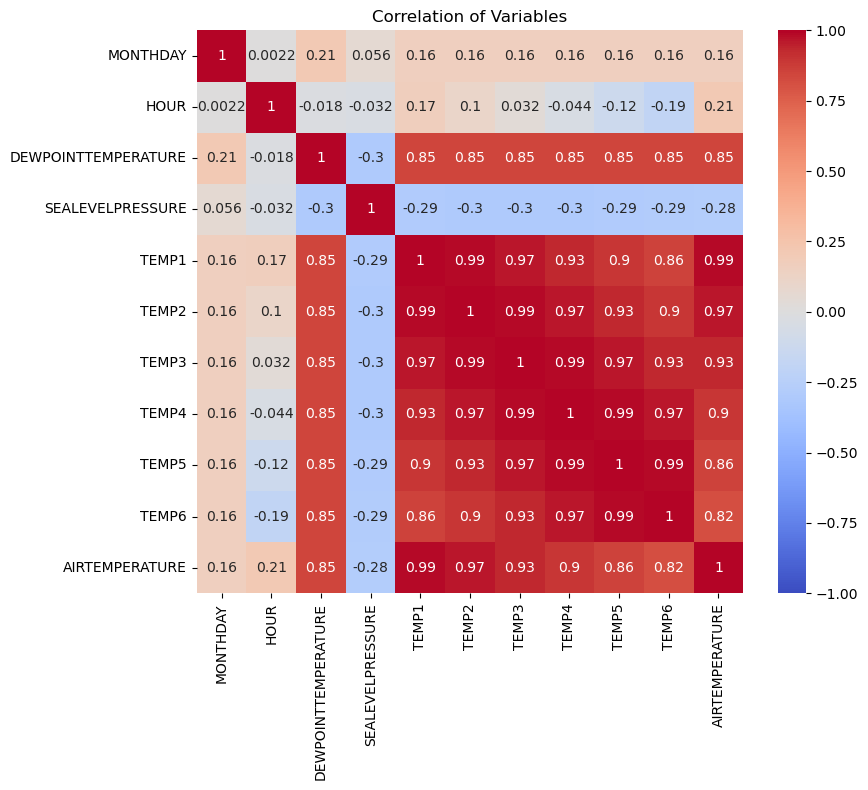

In [22]:
fig,ax = plt.subplots(figsize=(9,8))
sns.heatmap(df_new.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax)
ax.set_title('Correlation of Variables')
fig.tight_layout()

    The prior temperatures are the highest correlated variables to the AIRTEMPERATURE, as well as to each other. The DEWPOINTTEMPERATURE is also highly correlated with all the temperatures, including AIRTEMPERATURE.

C:\Users\elder\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


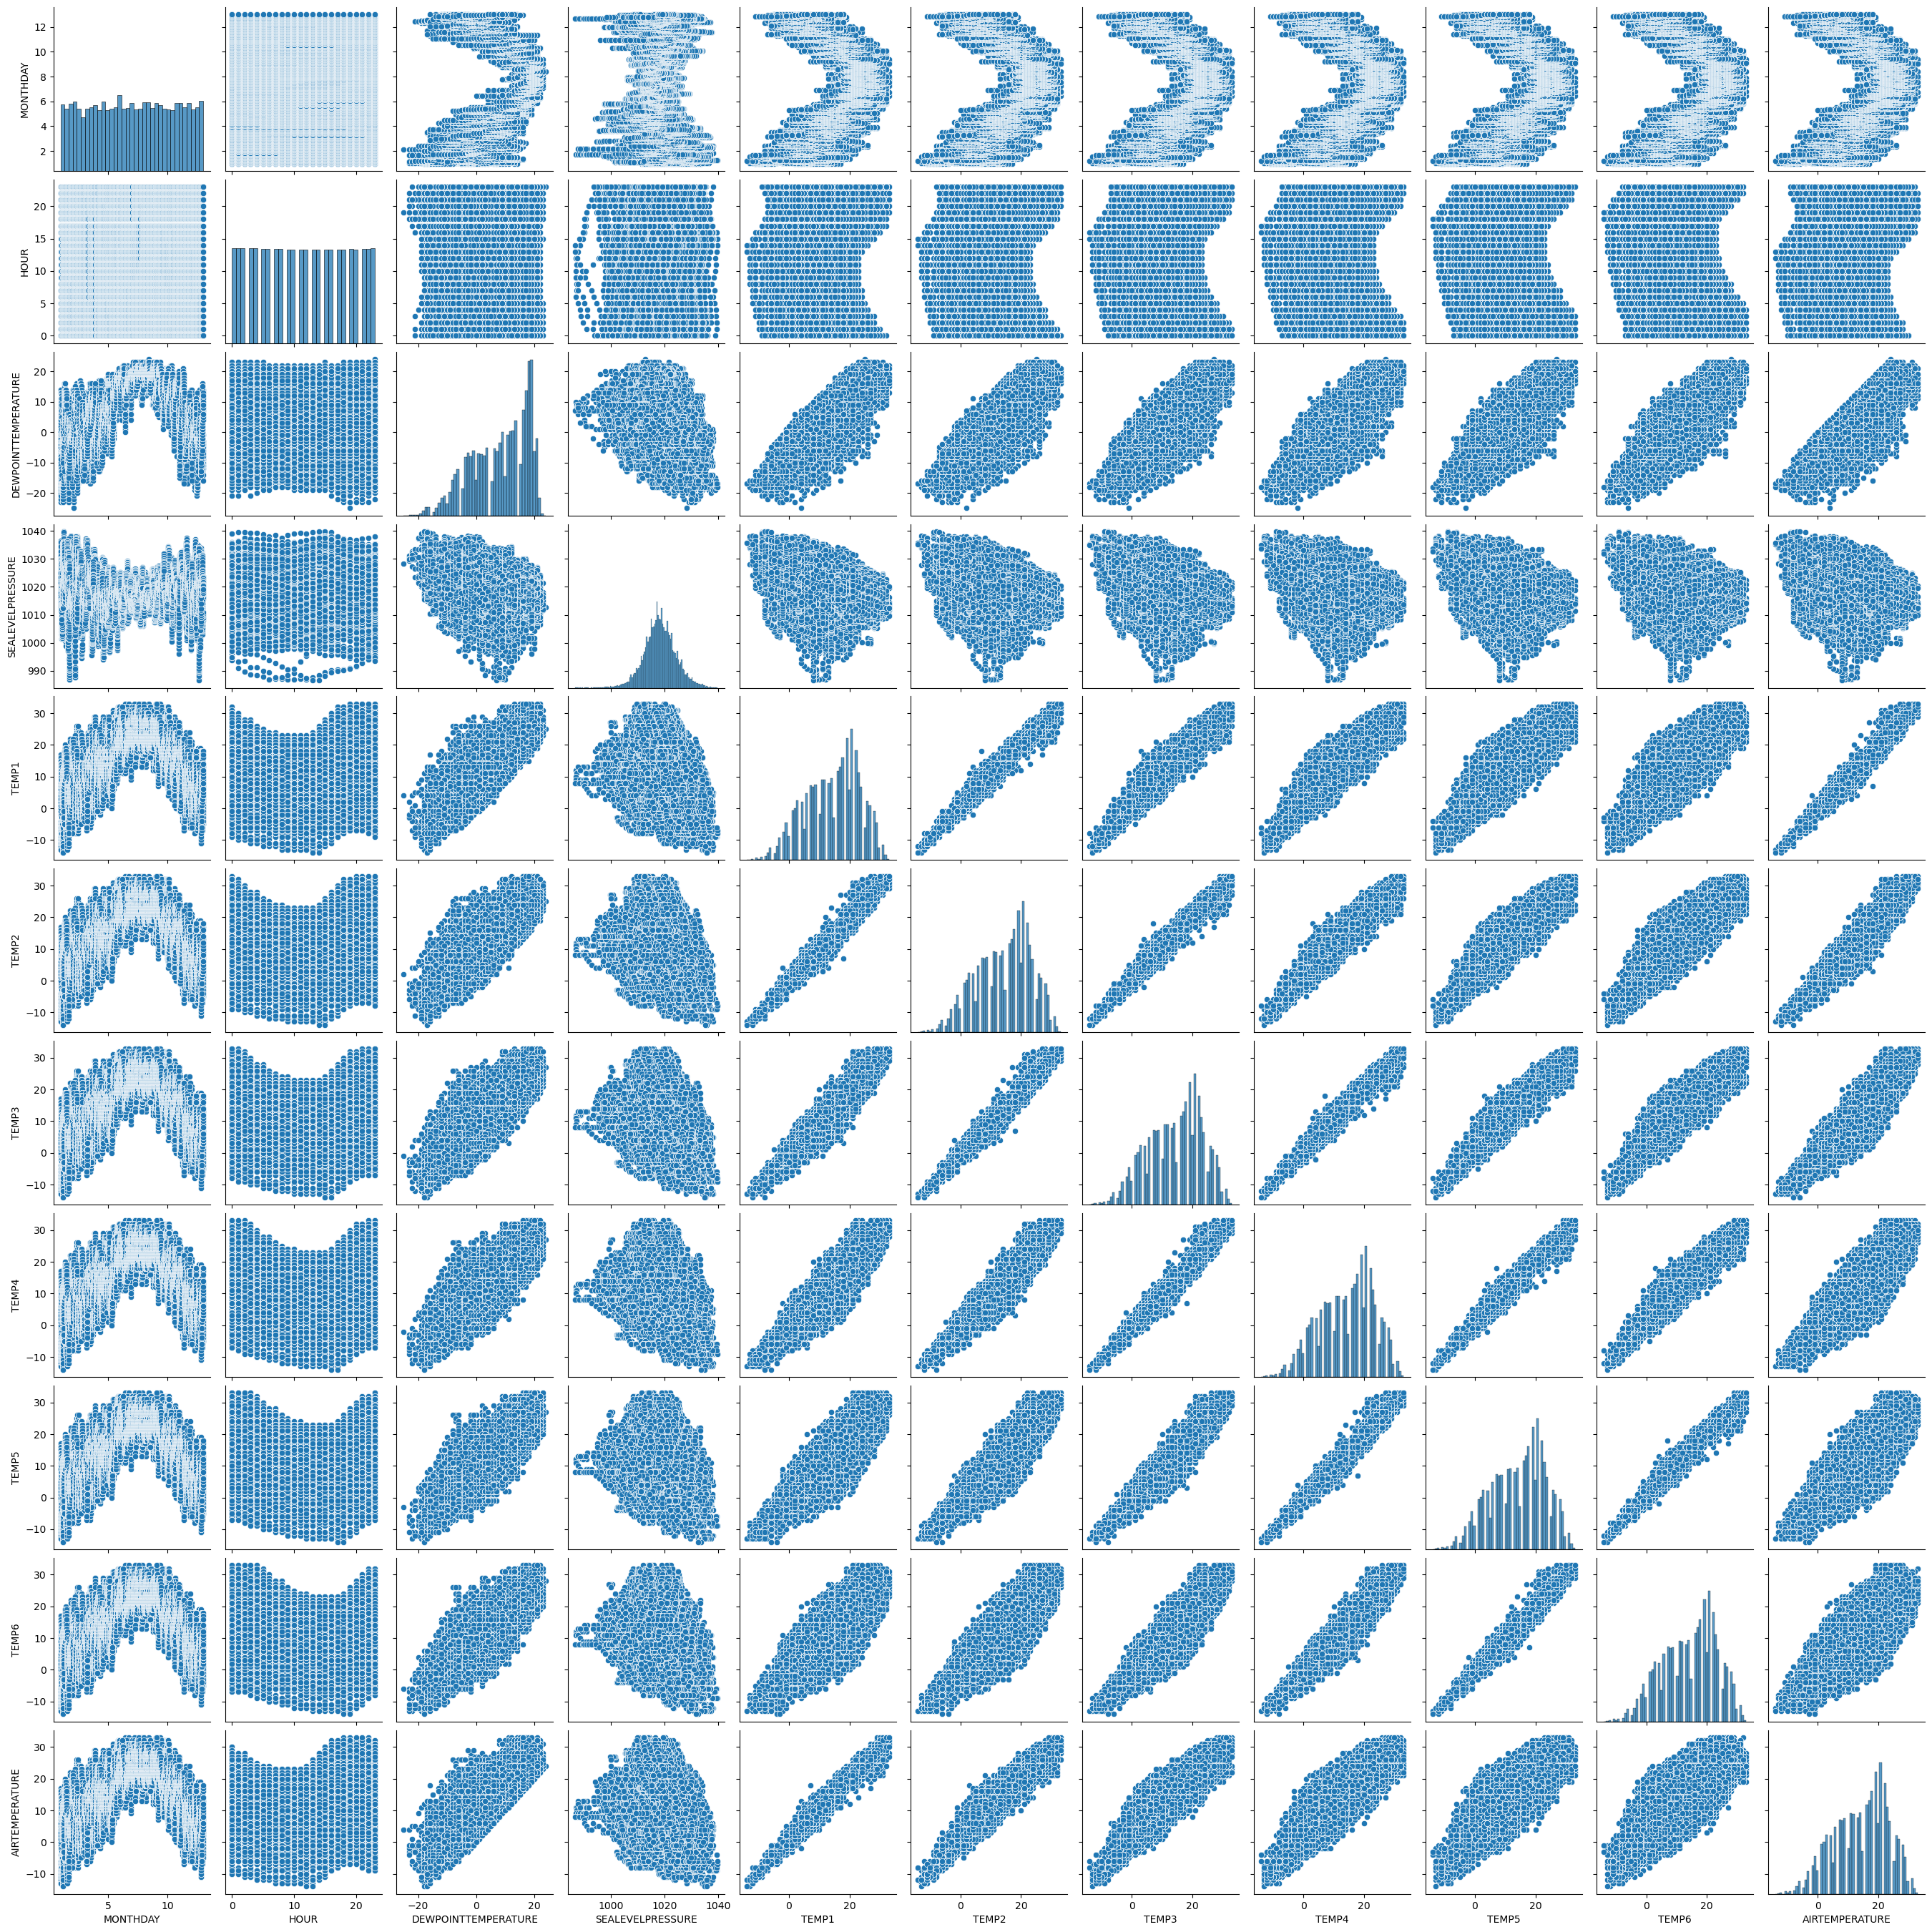

In [23]:
sns.pairplot(df_new)
plt.show()

    The pairplat show a linear relationship between all the temperatures. 

B. Full model: Model all variables using ols regression, and display a model summary

In [25]:
model_full = smf.ols('y ~ MONTHDAY + HOUR + DEWPOINTTEMPERATURE + SEALEVELPRESSURE + TEMP1 + TEMP2 + TEMP3 + TEMP4 + TEMP5 + TEMP6', data=df_new).fit()

print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.720e+05
Date:                Tue, 31 Oct 2023   Prob (F-statistic):               0.00
Time:                        05:32:42   Log-Likelihood:                -64241.
No. Observations:               42277   AIC:                         1.285e+05
Df Residuals:                   42266   BIC:                         1.286e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -10.7064    

C. P-test selection: Use the p-test results to manually select the best variables. Display a model summary of the best p-test model.

    All the variables are significant with p < 0.001, lets take a closer look at the actual values.

In [26]:
# look at the p values
model_full.pvalues.sort_values(ascending=False)

TEMP5                   9.762288e-06
TEMP6                   4.305191e-06
MONTHDAY                5.972855e-09
TEMP4                   1.403767e-18
Intercept               1.798581e-28
SEALEVELPRESSURE        4.784631e-31
TEMP2                   2.374356e-40
TEMP3                   5.569244e-78
HOUR                   5.525075e-139
DEWPOINTTEMPERATURE     0.000000e+00
TEMP1                   0.000000e+00
dtype: float64

    All p values are less than 0.00001. There is no need to do any p-test selction.

D. AIC selection: Use the AIC analysis code to create a set of models. Display a model summary of the best AIC model.

In [30]:
# Create list of all variable combinations
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s,r) for r in range(1, len(s)+1))

var_comb_list = list(powerset(list(X.columns)))
var_comb_list = [list(row) for row in var_comb_list]

In [31]:
AIC_scores = pd.DataFrame(columns=['AIC'])
for i in range(len(var_comb_list)):
    AIC_scores.loc[i,'AIC'] = sm.OLS(y,X[var_comb_list[i]]).fit().aic

In [38]:
# look at the top 5 AIC scores
AIC_scores.sort_values(by='AIC',ascending=True).head()

AIC
2046  128504.592195
2036  128522.154896
1980  128523.697097
2035  128523.721869
2044  128536.444896

In [59]:
minidx = AIC_scores.astype('float').idxmin()
print(minidx)

AIC    2046
dtype: int64


In [58]:
model_aic = sm.OLS(y,X[var_comb_list[minidx['AIC']]]).fit()
print(model_aic.summary())

                            OLS Regression Results                            
Dep. Variable:         AIRTEMPERATURE   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.720e+05
Date:                Tue, 31 Oct 2023   Prob (F-statistic):               0.00
Time:                        06:02:17   Log-Likelihood:                -64241.
No. Observations:               42277   AIC:                         1.285e+05
Df Residuals:                   42266   BIC:                         1.286e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -10.7064    

    Notice that this is just the full model.

E. RFE selection: Use the "RFE iteration" code to find the minimum set of features that achieves score = 0.980. Display a model summary of the best RFE model

In [70]:
from sklearn.feature_selection import RFE
from sklearn import linear_model

model = linear_model.LinearRegression()

print("\nSearch the fewest features that achieve a score of 0.980")

for k in range(1, 11):
    # rfe = RFE(model, k)
    rfe = RFE(estimator = model, n_features_to_select = k)

    fit = rfe.fit(X, y) 

    f = fit.get_support(1) #the most important features

    # final_features = data[data.columns[f]] # final features: this gives wrong results
    final_features = X[X.columns[f]] # final features
    
    print("Num Features: %d" % fit.n_features_)
    print("Selected Features: %s" % final_features.columns)
    print("Score: %2.3f" % fit.score(X,y))
    print("----------")
    if fit.score(X,y) >= 0.980:
        break


        


Search the fewest features that achieve a score of 0.980
Num Features: 1
Selected Features: Index(['TEMP1'], dtype='object')
Score: 0.977
----------
Num Features: 2
Selected Features: Index(['TEMP1', 'TEMP3'], dtype='object')
Score: 0.983
----------


    The score is greater than 0.980 with just a two features, TEMP1 and TEMP3

In [69]:
model_rfe = smf.ols('y ~ TEMP1 + TEMP3', data=df_new).fit()
print(model_rfe.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.208e+06
Date:                Tue, 31 Oct 2023   Prob (F-statistic):               0.00
Time:                        06:16:36   Log-Likelihood:                -66716.
No. Observations:               42277   AIC:                         1.334e+05
Df Residuals:                   42274   BIC:                         1.335e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3191      0.011     29.455      0.0

    With just two features the Adj R-squared and AIC scores are only slightly worse than the full model. This is a much simpler model though and does not have the strong multicolinearity.  
    Lets view how the score changes with more features

In [74]:
for k in range(1, 11):
    # rfe = RFE(model, k)
    rfe = RFE(estimator = model, n_features_to_select = k)

    fit = rfe.fit(X, y) 

    f = fit.get_support(1) #the most important features

    # final_features = data[data.columns[f]] # final features: this gives wrong results
    final_features = X[X.columns[f]] # final features
    
    print("Num Features: %d" % fit.n_features_)
    print("Selected Features: %s" % final_features.columns)
    print("Score: %2.3f" % fit.score(X,y))
    print("----------")

Num Features: 1
Selected Features: Index(['TEMP1'], dtype='object')
Score: 0.977
----------
Num Features: 2
Selected Features: Index(['TEMP1', 'TEMP3'], dtype='object')
Score: 0.983
----------
Num Features: 3
Selected Features: Index(['TEMP1', 'TEMP2', 'TEMP3'], dtype='object')
Score: 0.983
----------
Num Features: 4
Selected Features: Index(['TEMP1', 'TEMP2', 'TEMP3', 'TEMP4'], dtype='object')
Score: 0.983
----------
Num Features: 5
Selected Features: Index(['DEWPOINTTEMPERATURE', 'TEMP1', 'TEMP2', 'TEMP3', 'TEMP4'], dtype='object')
Score: 0.984
----------
Num Features: 6
Selected Features: Index(['HOUR', 'DEWPOINTTEMPERATURE', 'TEMP1', 'TEMP2', 'TEMP3', 'TEMP4'], dtype='object')
Score: 0.985
----------
Num Features: 7
Selected Features: Index(['HOUR', 'DEWPOINTTEMPERATURE', 'TEMP1', 'TEMP2', 'TEMP3', 'TEMP4', 'TEMP5'], dtype='object')
Score: 0.985
----------
Num Features: 8
Selected Features: Index(['HOUR', 'DEWPOINTTEMPERATURE', 'TEMP1', 'TEMP2', 'TEMP3', 'TEMP4', 'TEMP5', 'TEMP6'],

    Notice that there is only a slight increase in the score as more features are added, especially above 5 features, but even after just 2 features.  
    The features that do not contirbute to improving model performance are, in order of the lowest contribution: MONTHDAY, SEALEVELPRESSURE, TEMP6, TEMP5, HOUR, DEWPOINTTEMPERATURE, TEMP4, TEMP2

## Section 3: Model Evaluation


A. I have enhanced readability by using the template with text blocks & code blocks

B.200+ word evaluation of the modeling efforts:   
   
blah blah

